<h3> [MUCURI] Previsão de horas a frente </h3>

Importando o tensorflow, o keras e as bibliotecas que serão usadas

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Activation
from tensorflow.python.keras.optimizers import adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import ai_utils.metrics as ai
import sklearn as sk

Lendo o dataset e tratando os valores nulos 

In [16]:
Mucuri = pd.read_csv('./train150_mucuri.txt', sep='\t', header = None)
Mucuri_prev = pd.read_csv('./prev150_mucuri.txt', sep='\t', header = None)
Mucuri.update(Mucuri[6].fillna(Mucuri[6].mean()))
Mucuri.describe()

,0,1,2,3,4,5,6,7,8
count,550.000000,550.000000,550.0,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,12.087273,11.981818,2015.0,11.496364,8.176719,73.027647,24.443445,85.263578,1017.313986
std,6.891273,0.133730,0.0,6.940745,2.724988,64.996263,1.668117,8.579562,8.796185
min,1.000000,11.000000,2015.0,0.000000,1.211905,1.448179,20.616279,46.355556,937.534333
25%,6.000000,12.000000,2015.0,5.250000,6.215278,38.605367,23.315657,80.942222,1016.544542
50%,12.000000,12.000000,2015.0,11.000000,8.320000,59.019307,24.338280,86.765805,1020.046750
75%,18.000000,12.000000,2015.0,17.750000,10.146806,83.329498,25.359083,91.434531,1021.497917
max,30.000000,12.000000,2015.0,23.000000,13.572222,356.553715,30.140625,98.000000,1023.726500


Transformando o dataset em um numpy array e separando a coluna da velocidade do vento

In [17]:
x_array = Mucuri.values 
y_array = list(Mucuri[4].values)

Criando o modelo da rede

In [18]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='relu', input_shape=(9,)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
  ])

  model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])
  return model

Treinando a rede em 6 épocas

In [19]:
model = get_compiled_model()
history = model.fit(x_array, y_array, epochs=6, validation_split=0.2)

Train on 440 samples, validate on 110 samples
Epoch 1/6
440/440 [==============================] - 0s 304us/sample - loss: 1510.8605 - mean_absolute_error: 31.2497 - val_loss: 749.4369 - val_mean_absolute_error: 27.2777
Epoch 2/6
440/440 [==============================] - 0s 57us/sample - loss: 283.7919 - mean_absolute_error: 14.0823 - val_loss: 154.2952 - val_mean_absolute_error: 12.1939
Epoch 3/6
440/440 [==============================] - 0s 54us/sample - loss: 79.9023 - mean_absolute_error: 7.6157 - val_loss: 27.0755 - val_mean_absolute_error: 4.6485
Epoch 4/6
440/440 [==============================] - 0s 66us/sample - loss: 27.3764 - mean_absolute_error: 4.2809 - val_loss: 16.8167 - val_mean_absolute_error: 3.5810
Epoch 5/6
440/440 [==============================] - 0s 59us/sample - loss: 13.5326 - mean_absolute_error: 2.9422 - val_loss: 6.8389 - val_mean_absolute_error: 2.0975
Epoch 6/6
440/440 [==============================] - 0s 59us/sample - loss: 10.1556 - mean_absolute_error

In [20]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


Gráfico de evolução do loss de treinamento e validação ao longo das épocas 

[1510.8605223915795, 283.7919317072088, 79.9022614218972, 27.376375007629395, 13.532612401788885, 10.15560660795732]


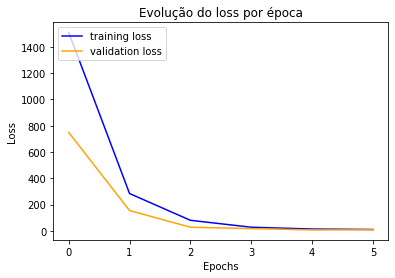

In [21]:
print(history.history['loss'])
plt.plot(history.history['loss'], color = 'blue', label='training loss')
plt.plot(history.history['val_loss'], color = 'orange', label='validation loss') 
plt.legend(loc='upper left')
plt.title('Evolução do loss por época')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
lossEvaluate, acc = model.evaluate(x_array, y_array)

550/550 [==============================] - 0s 33us/sample - loss: 9.5520 - mean_absolute_error: 2.5467


Manipulando o dataset para previsão

In [24]:
p1_array = x_array[1:550, 0:4]
p2_array = x_array[0:549, 5:]
w_array = model.predict(x_array)
w_array = w_array[0:549, :]

print(w_array.shape)
print(p1_array.shape)
print(p2_array.shape)

new_array = np.hstack((p1_array, w_array, p2_array))

(549, 1)
(549, 4)
(549, 4)


Previsão e comparação gráfica entre o previsto e o observado

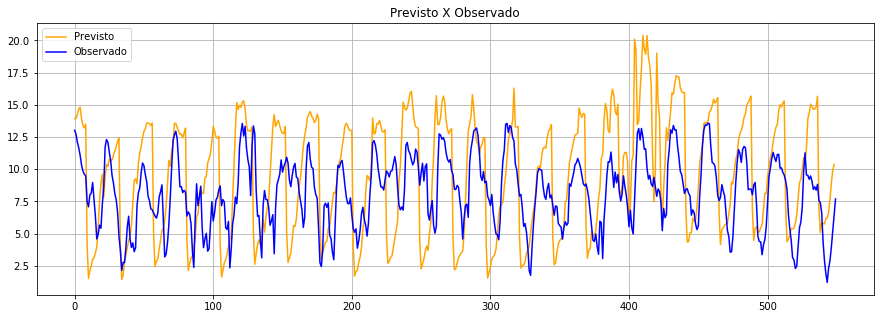

In [28]:
vel = model.predict(new_array)

plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(vel, color='orange', label='Previsto')
plt.plot(y_array, color='blue', label='Observado') 
plt.legend(loc='upper left')
plt.title('Previsto X Observado')
plt.show()

Métricas para avaliação: R, R2, Fac2, MSE e MAE

In [26]:
mae = sk.metrics.mean_absolute_error(w_array, vel)
mse = sk.metrics.mean_squared_error(w_array, vel)
R2 = sk.metrics.r2_score(w_array, vel)

predconvert = tf.convert_to_tensor(vel)
realconvert = tf.convert_to_tensor(w_array)
R = ai.pearson_r(realconvert, predconvert, to_numpy=True)
Fac2 = ai.fac2(realconvert, predconvert, to_numpy=True)

print('MAE: ', mae)
print('MSE: ', mse)
print('R2: ', R2)
print('R: ', R)
print('Fac2: ', Fac2)

MAE:  1.1874573
MSE:  3.21362
R2:  0.7805008591610477
R:  0.9225396
Fac2:  0.97085613


Manipulando os dados do dataset de teste

In [30]:
Mucuri_prev = pd.read_csv('./prev150_mucuri.txt', sep='\t', header = None)
Mucuri_prev.update(Mucuri_prev[6].fillna(Mucuri_prev[6].mean()))
Mucuri_prev.describe()

,0,1,2,3,4,5,6,7,8
count,194.000000,194.0,194.0,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,27.041237,12.0,2015.0,11.510309,9.188695,64.919170,24.242613,86.860762,1014.358564
std,2.373941,0.0,0.0,6.905160,2.706189,35.644006,1.346325,7.189586,4.210357
min,23.000000,12.0,2015.0,0.000000,3.820000,1.736042,18.936170,61.527778,1005.772500
25%,25.000000,12.0,2015.0,6.000000,7.050278,43.032883,23.375000,83.756944,1010.976500
50%,27.000000,12.0,2015.0,12.000000,9.121944,63.737405,24.170290,87.990643,1013.552417
75%,29.000000,12.0,2015.0,17.000000,11.268521,83.516536,25.408914,92.224818,1018.184250
max,31.000000,12.0,2015.0,23.000000,15.313889,338.940891,27.735294,98.710843,1021.089833


In [31]:
xPrev_array = Mucuri_prev.values 
yPrev_array = list(Mucuri_prev[4].values)

In [43]:
p1Prev_array = xPrev_array[1:194, 0:4]
p2Prev_array = xPrev_array[0:193, 5:]
wPrev_array = model.predict(xPrev_array)
wPrev_array = wPrev_array[0:193, :]

print(wPrev_array.shape)
print(p1Prev_array.shape)
print(p2Prev_array.shape)

Prev_array = np.hstack((p1Prev_array, wPrev_array, p2Prev_array))

(193, 1)
(193, 4)
(193, 4)


Previsão e comparação gráfica entre o previsto e o observado usando o dataset de teste

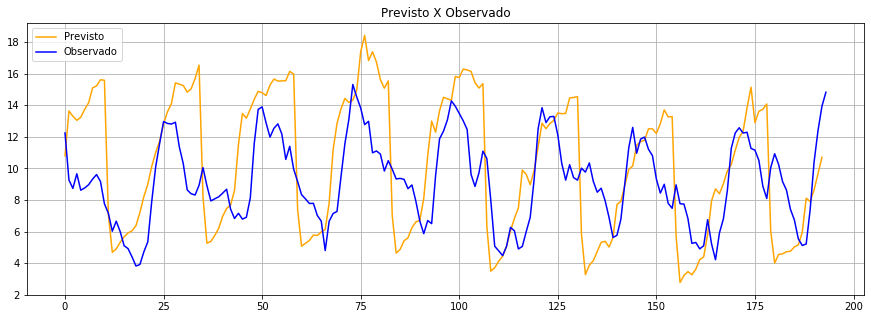

In [45]:
pred = model.predict(Prev_array)

plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(pred, color='orange', label='Previsto')
plt.plot(yPrev_array, color='blue', label='Observado') 
plt.legend(loc='upper left')
plt.title('Previsto X Observado')
plt.show()

In [47]:
mae = sk.metrics.mean_absolute_error(wPrev_array, pred)
mse = sk.metrics.mean_squared_error(wPrev_array, pred)
R2 = sk.metrics.r2_score(wPrev_array, pred)

predconvert = tf.convert_to_tensor(pred)
realconvert = tf.convert_to_tensor(wPrev_array)
R = ai.pearson_r(realconvert, predconvert, to_numpy=True)
Fac2 = ai.fac2(realconvert, predconvert, to_numpy=True)

print('MAE: ', mae)
print('MSE: ', mse)
print('R2: ', R2)
print('R: ', R)
print('Fac2: ', Fac2)

MAE:  1.0683638
MSE:  2.9877884
R2:  0.7838700847941376
R:  0.9174204
Fac2:  0.97409326
